In [1]:
from pylab import * 
import numpy as np
import matplotlib as mtp
import matplotlib.pyplot as plt
from sklearn import *

In [3]:
# Projektaufgaben
#1 Daten importieren
#2 Aus den Daten Linearen Plot auslesen
#3 linearen fit entfernen
#4 plot oben und unten mitteln
#5 Volt Werte zu Polarisation umwandeln

In [4]:
#Datenimport Erste Probe

#Faraday
data1 = genfromtxt(fname="../Erste Probe/faraday1/all_data.txt", delimiter="")
field1 = data1[:,0]
voltage1 = data1[:,1]
std1 = data1[:,2]
direction1 = data1[:,3]
loop1 = data1[:,4]  

#faraday1diodecalibration
calib1 = genfromtxt(fname="../Erste Probe/calibfara/diode_calibration.txt",delimiter="")
polangle1 = calib1[:,0]
diodevoltage1 = calib1[:,1]
diodestd1 = calib1[:,2]

#kerrmethod1
data2 = genfromtxt(fname="../Erste Probe/kerr-messung1/all_data.txt", delimiter="")
fieldtwo = data2[:,0]
voltage2 = data2[:,1]
std2 = data2[:,2]
direction2 = data2[:,3]
loop2 = data2[:,4]

#kerrmethod2
data3 = genfromtxt(fname="../Erste Probe/kerr-messung2/all_data.txt", delimiter="")
field3 = data3[:,0]
voltage3 = data3[:,1]
std3 = data3[:,2]
direction3 = data3[:,3]
loop3 = data3[:,4] 

#kerr1diodecalibration
calib2 = genfromtxt(fname="../Erste Probe/calibrationkerrmethod/diode_calibration.txt",delimiter="")
polangle2 = calib2[:,0]
diodevoltage2 = calib2[:,1]
diodestd2 = calib2[:,2]



#Datenimport zweite Probe
#Faraday
data4 = genfromtxt(fname="../Zweite Probe/faraday/all_data.txt", delimiter="")
field4 = data4[:,0]
voltage4 = data4[:,1]
std4 = data4[:,2]
direction4 = data4[:,3]
loop4 = data4[:,4]  


#faraday1diodecalibration
calib3 = genfromtxt(fname="../Zweite Probe/faraday/diode_calibration.txt",delimiter="")
polangle3 = calib3[:,0]
diodevoltage3 = calib3[:,1]
diodestd3 = calib3[:,2]



Text(0, 0.5, 'polarization angle $\\theta(°)$')

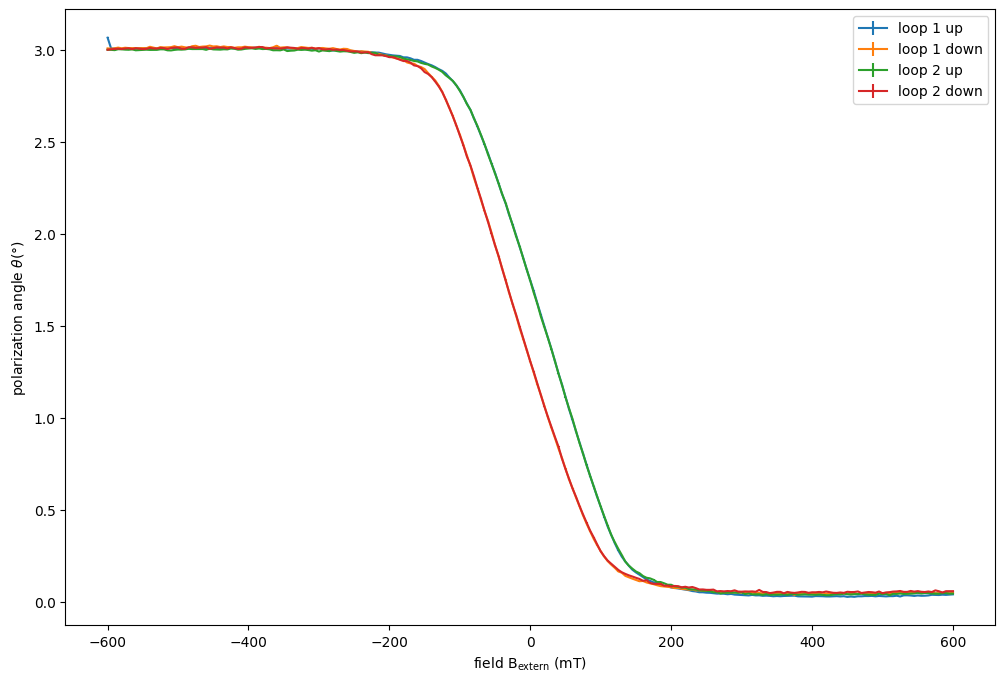

In [5]:
select_up = direction1 > 0
select_down = direction1 <= 0

#Neue Variable, damit ich die hier zu exemplarischen Zwecken überschreiben kann.
exvoltage1 = voltage1
diodevoltage = diodevoltage1
polangle = polangle1
diodestd = diodestd1

reg = linear_model.LinearRegression()
xres = field1[1:60].reshape(-1,1)
reg.fit(xres,exvoltage1[1:60], sample_weight=1/std1[1:60])
m = reg.coef_
b = reg.intercept_
rscore = reg.score(xres, exvoltage1[1:60])

exvoltage1 = exvoltage1 - (m*field1+b)


midvalue = np.mean(exvoltage1[1:])
exvoltage1 = exvoltage1-midvalue


#Kalibrationskurve berechnen und Umrechnung V->°
reg1 = linear_model.LinearRegression()
calib = diodevoltage.reshape(-1,1)
reg1.fit(calib,polangle,sample_weight=1/diodestd)
m1 = reg1.coef_
b1 = reg1.intercept_
exvoltage1 = m1*exvoltage1+b1


field_up_1 = field1[(select_up) & (loop1 == 1)]
field_down_1 = field1[(select_down) & (loop1 == 1)]
voltage_up_1 = exvoltage1[(select_up) & (loop1 == 1)]
voltage_down_1 = exvoltage1[(select_down) & (loop1 == 1)]
std_up_1 = std1[(select_up) & (loop1 == 1)]
std_down_1 = std1[(select_down) & (loop1 == 1)]

field_up_2 = field1[(select_up) & (loop1 == 2)]
field_down_2 = field1[(select_down) & (loop1 == 2)]
voltage_up_2 = exvoltage1[(select_up) & (loop1 == 2)]
voltage_down_2 = exvoltage1[(select_down) & (loop1 == 2)]
std_up_2 = std1[(select_up) & (loop1 == 2)]
std_down_2 = std1[(select_down) & (loop1 == 2)]


plt.figure(figsize=(12,8))

#plt.plot(field1, m*field1+b,label="linear fit")

plt.errorbar(field_up_1,voltage_up_1, yerr = std_up_1, label = "loop 1 up")
plt.errorbar(field_down_1,voltage_down_1, yerr = std_down_2, label = "loop 1 down")
plt.errorbar(field_up_2,voltage_up_2, yerr = std_up_2, label = "loop 2 up")
plt.errorbar(field_down_2,voltage_down_2, yerr = std_down_2, label = "loop 2 down")
plt.legend(loc = 0)
plt.xlabel(r"field B$_\mathrm{extern}$ (mT)")
plt.ylabel(r"polarization angle $\theta(°)$")
#plt.ylabel(r"diode voltage $U$ (V)") 

In [6]:
#Genauigkeit eines linearen Fits ab Wert n berechnen und ausgeben
def calibratelinearfit(x,y,weight,n, k):
    """Manuelles Fitting von Wert n bis k"""
    reg = linear_model.LinearRegression()
    xres = x[n:k].reshape(-1,1)
    reg.fit(xres,y[n:k], sample_weight=1/weight[n:k])
    m = reg.coef_
    b = reg.intercept_
    rscore = reg.score(xres, y[n:k])
    plt.figure(figsize=(12,8))
    plt.legend(loc=0)
    plt.plot(xres, y[n:k])
    plt.plot(xres, m*xres+b)
    plt.xlabel(r"field B$_\mathrm{extern}$ (mT)")
    plt.ylabel(r"diode voltage $U$(V)") 
    print(rscore,k)

In [22]:
#Hysteresekurve kalibrieren und Fit entfernene
def newfluxcalc(field,voltage,std,direction,loop,polangle,diodevoltage,diodestd,n,k):
    #Linearen Fit rausrechnen, mit den manuell bestimmten Werten
    reg = linear_model.LinearRegression()
    xres = field[n:k].reshape(-1,1)
    reg.fit(xres,voltage[n:k],sample_weight=1/std[n:k])
    m = reg.coef_
    b = reg.intercept_
    newy = voltage-(m*field+b)

    #Werte um die x-Achse mitteln ohne den ersten fehlerhaften Wert zu betrachten
    midvalue = np.mean(newy[n:]) 
    newval = newy-midvalue


    #Kalibrationskurve berechnen und Umrechnung V->°
    reg1 = linear_model.LinearRegression()
    calib = diodevoltage.reshape(-1,1)
    reg1.fit(calib,polangle,sample_weight=1/diodestd)
    m1 = reg1.coef_
    b1 = reg1.intercept_
    ypol = m1*newval+b1

    #Hier würde durch die Dicke der Probe geteilt
    yfinal = ypol/0.133

    #Der andere Kram hier noch einfügen
    select_up = direction > 0
    select_down = direction <= 0 
    
    field_up_1 = field[(select_up) & (loop == 1)]
    field_down_1 = field[(select_down) & (loop == 1)]
    voltage_up_1 = ypol[(select_up) & (loop == 1)]
    voltage_down_1 = ypol[(select_down) & (loop == 1)]
    std_up_1 = std[(select_up) & (loop == 1)]
    std_down_1 = std[(select_down) & (loop == 1)]

    field_up_2 = field[(select_up) & (loop == 2)]
    field_down_2 = field[(select_down) & (loop == 2)]
    voltage_up_2 = ypol[(select_up) & (loop == 2)]
    voltage_down_2 = ypol[(select_down) & (loop == 2)]
    std_up_2 = std[(select_up) & (loop == 2)]
    std_down_2 = std[(select_down) & (loop == 2)]


    plt.figure(figsize=(15,10))
    plt.errorbar(field_up_1,voltage_up_1, yerr = m1*std_up_1, label = "loop 1 up")
    plt.errorbar(field_down_1,voltage_down_1, yerr = m1*std_down_1, label = "loop 1 down")
    plt.errorbar(field_up_2,voltage_up_2, yerr = m1*std_up_2, label = "loop 2 up")
    plt.errorbar(field_down_2,voltage_down_2, yerr = m1*std_down_2, label = "loop 2 down")
    plt.legend(loc = 0)
    plt.xlabel(r"field B$_\mathrm{extern}$ (mT)")
    plt.ylabel(r"polarisation angle $\theta$(°)") 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9968706660306702 60


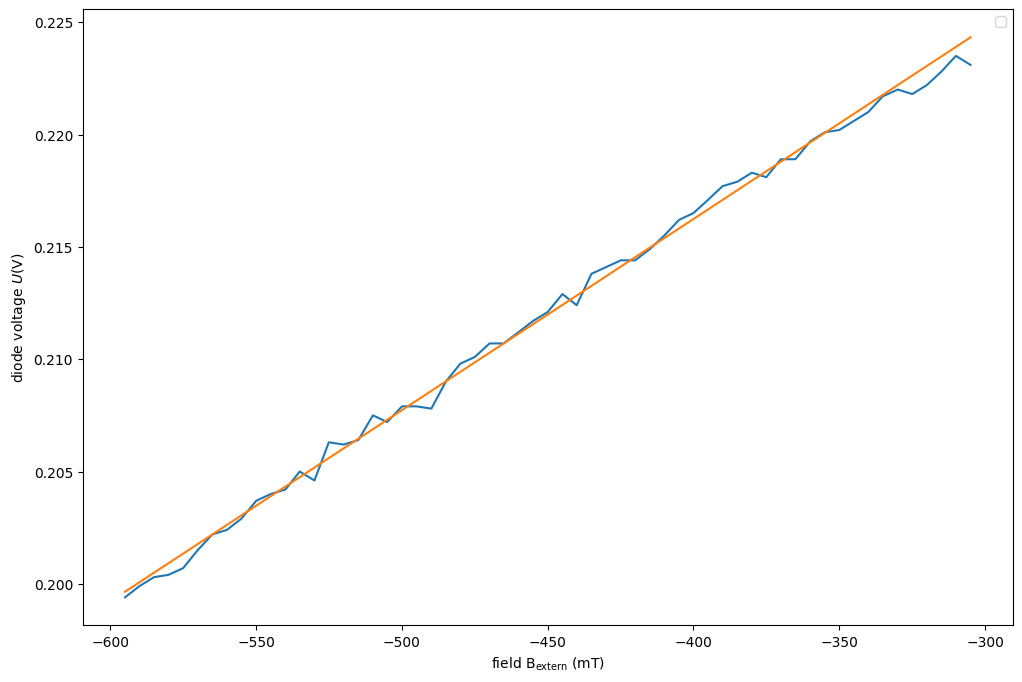

In [23]:
calibratelinearfit(field1, voltage1,std1, 1,60)

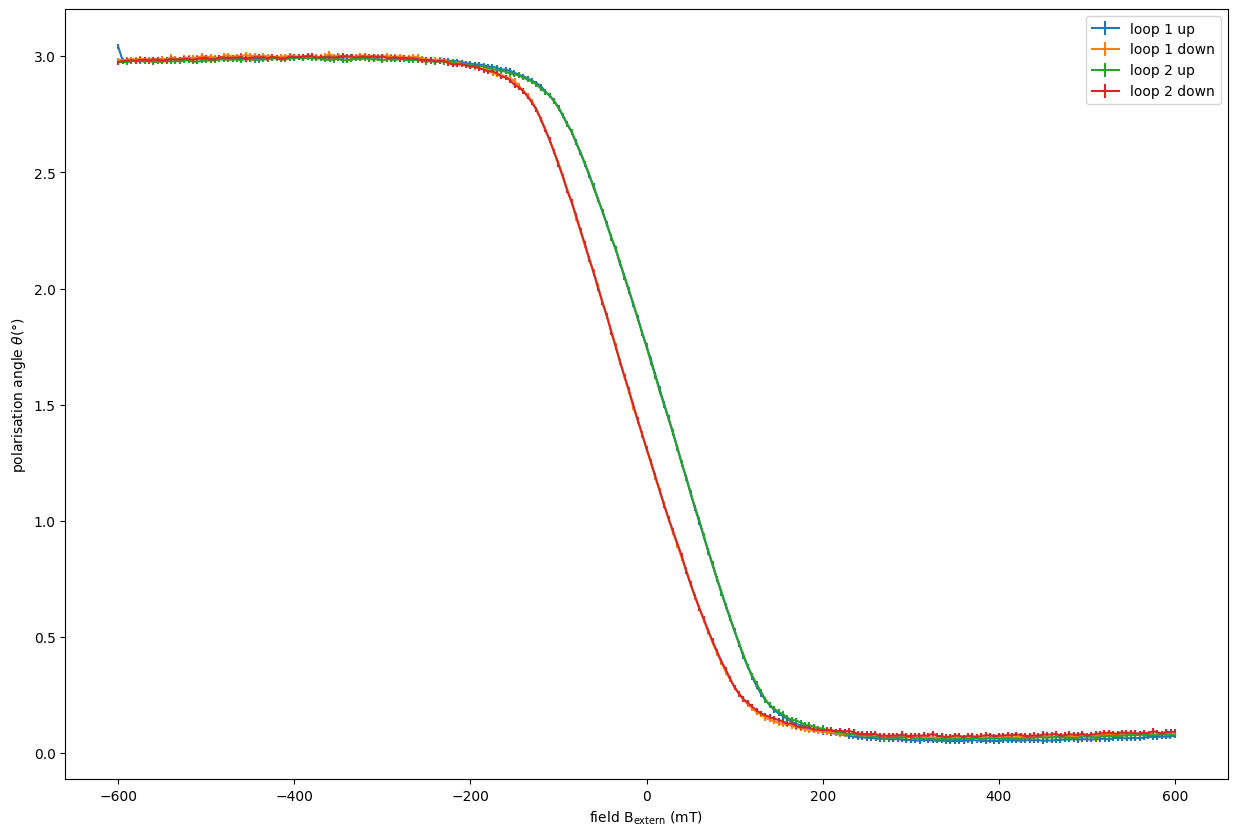

In [24]:
newfluxcalc(field1, voltage1,std1,direction1,loop1, polangle1, diodevoltage1, diodestd1, 5,80)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.96736976276036 60


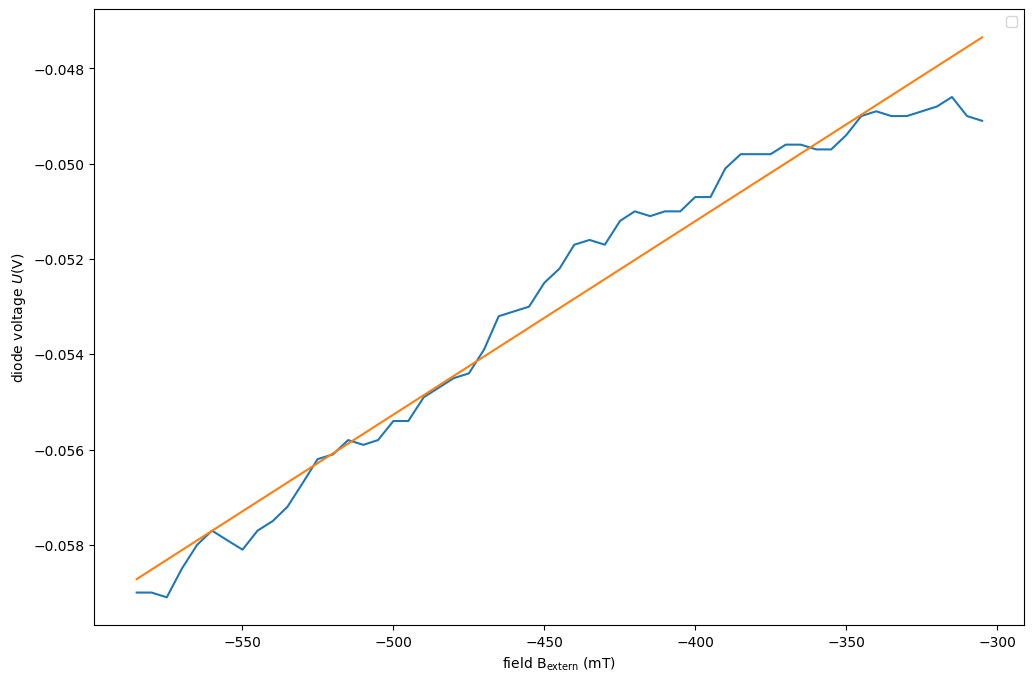

In [25]:
calibratelinearfit(fieldtwo,voltage2,std2, 3, 60)

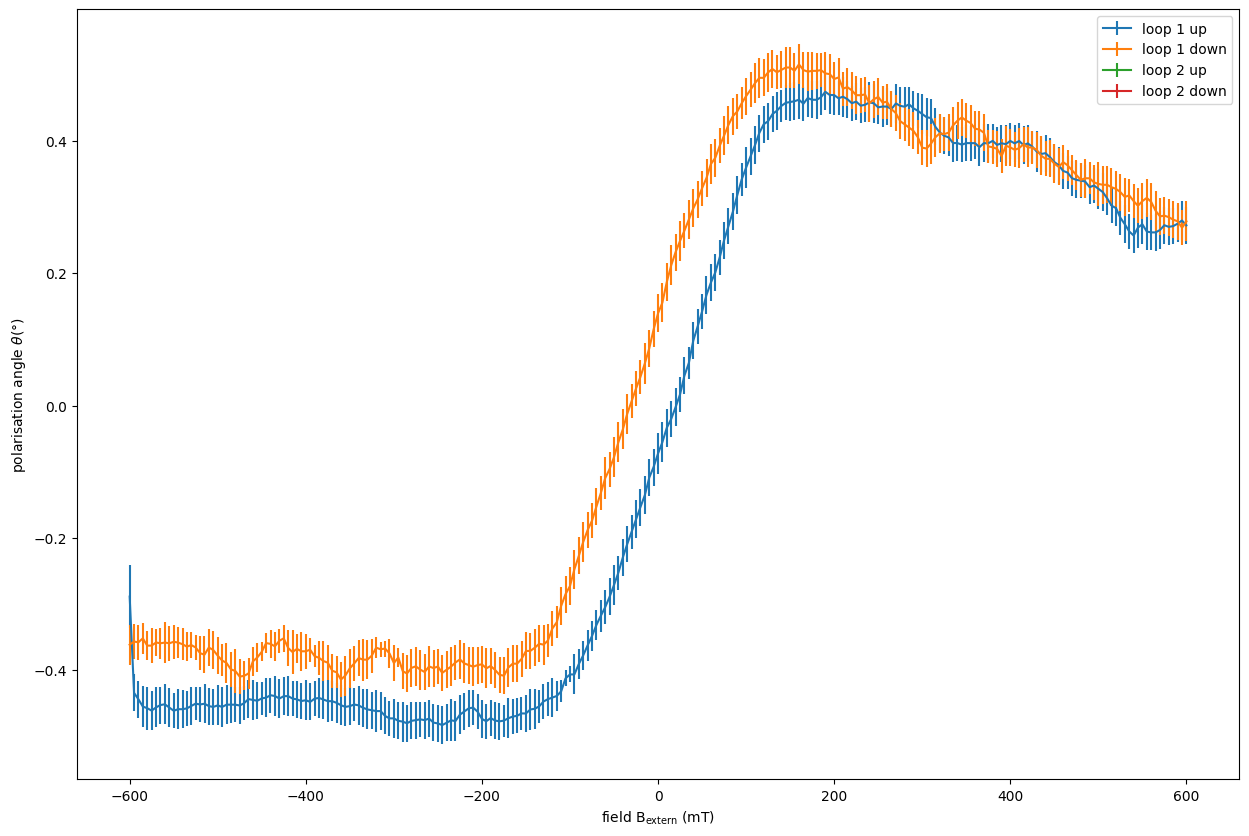

In [26]:
newfluxcalc(fieldtwo,voltage2, std2, direction2, loop2, polangle2, diodevoltage2, diodestd2, 3, 60)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.41468286403581667 80


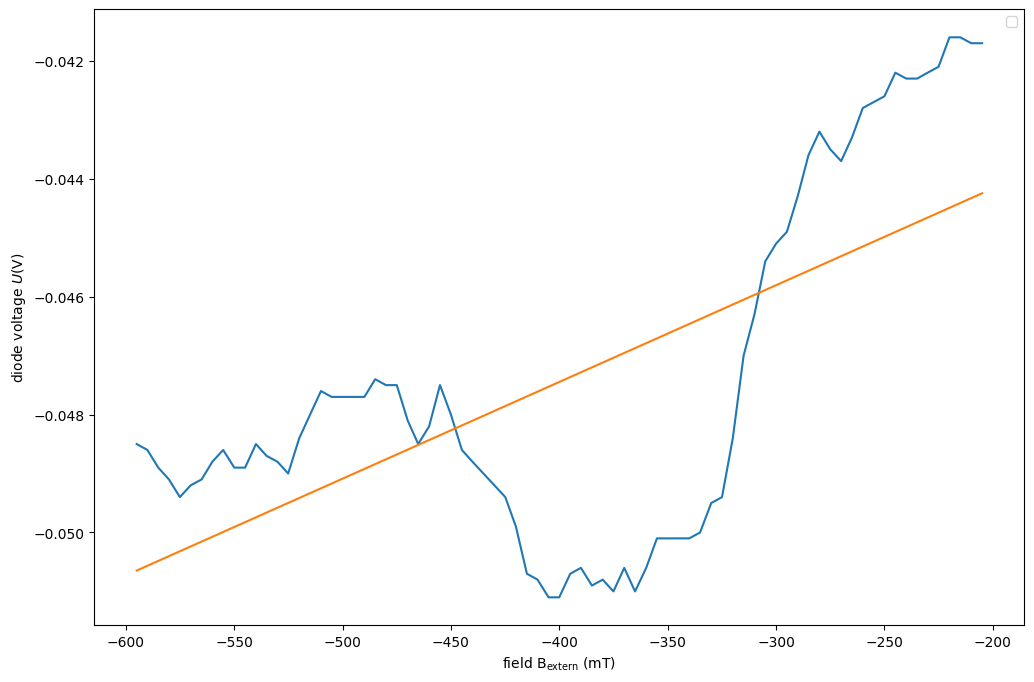

In [34]:
calibratelinearfit(field3, voltage3, std3,1,80)

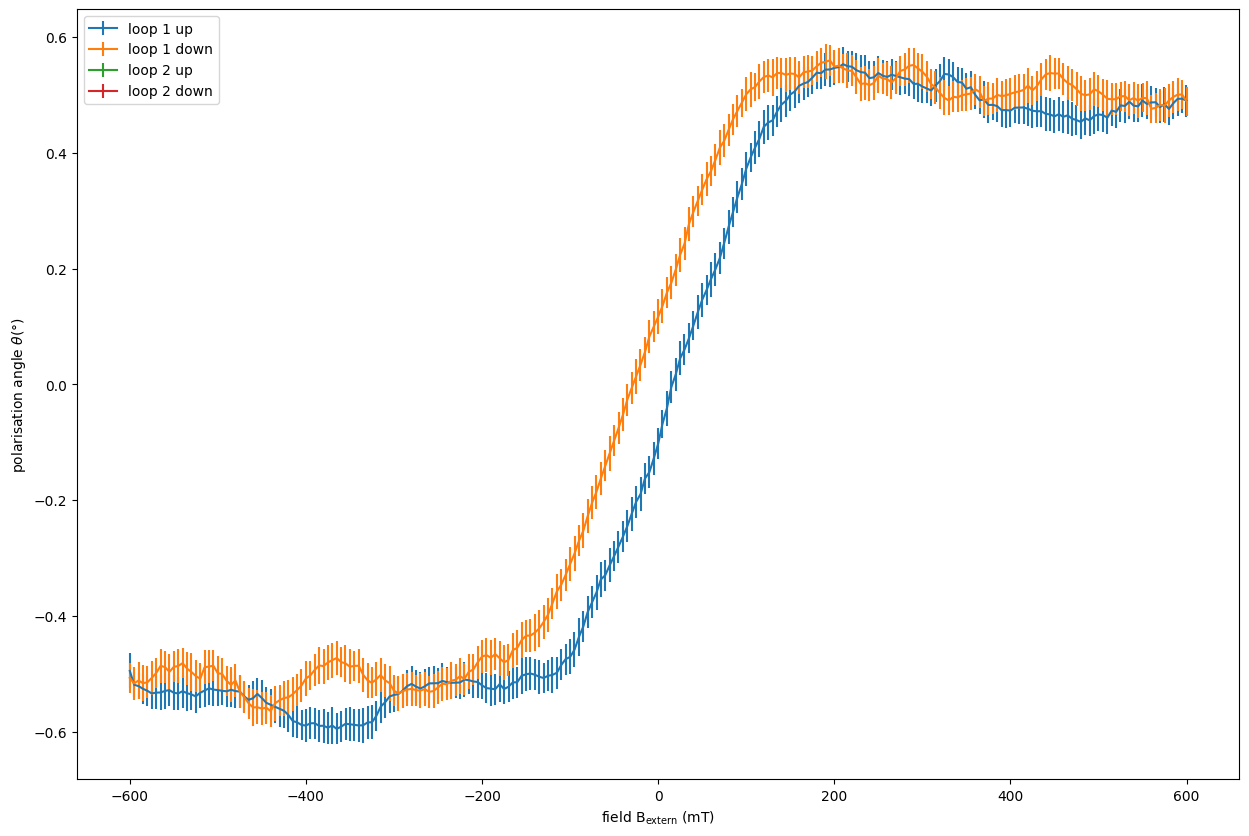

In [35]:
newfluxcalc(field3,voltage3, std3, direction3, loop3, polangle2, diodevoltage2, diodestd2, 1, 80)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.881174774498484 10


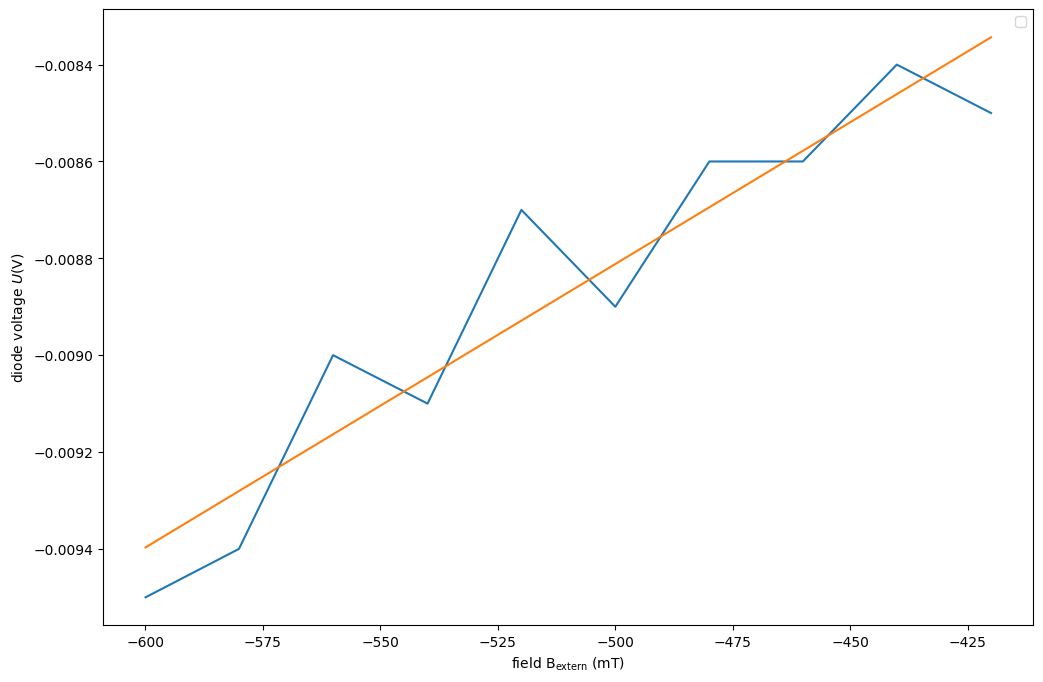

In [29]:
calibratelinearfit(field4,voltage4,std4,0,10)

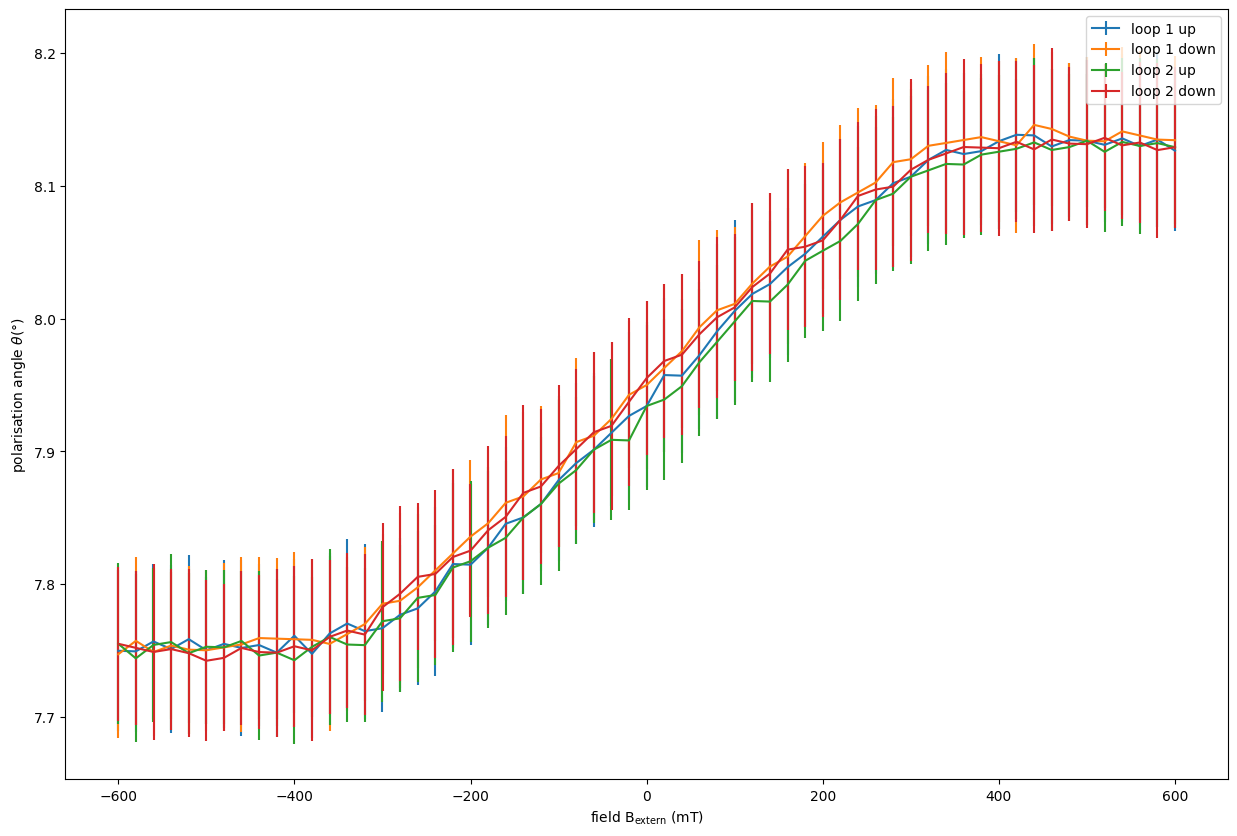

In [30]:
newfluxcalc(field4,voltage4,std4,direction4,loop4, polangle3,diodevoltage3,diodestd3,0,10)